### aim: combine streamlined-flux-corr-maker.ipynb, work_out_hosing.ipynb, and looping directory

### date: 

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [4]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [5]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import os
import sys

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import snippets as sp
reload(sp)

<module 'snippets' from '/gpfs/home/mep22dku/scratch/SOZONE/UTILS/snippets.py'>

In [6]:
dir(sp)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'sniplist',
 'tdf',
 'tfig',
 'tmask',
 'tmetro',
 'tmodi',
 'txr',
 'tylist']

## make forcing that adds a flux correction to a base forcing
    
#### make_and_symlink_flux_dirs(ndir, scal, yst = 1750, yen = 2025, odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/', earlyloopyr = 1990):
    originally in hosing/streamlined-flux-corr-maker.ipynb

Text(0.5, 1.0, 'global avg mean wfo diff, monthly \n (yearly mean v small: 2.3778268618516067e-08 kg/m2/s)')

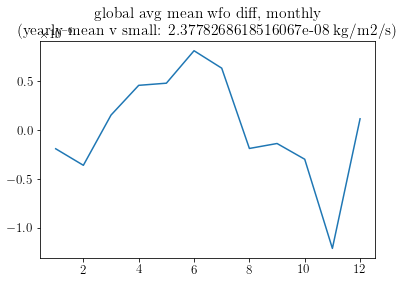

In [19]:
view = True
if view:

    tvar = 'wfo'
    KDD0 = xr.open_dataset(f'./data/KDD0_{tvar}.nc')
    KWD0 = xr.open_dataset(f'./data/KWD0_{tvar}.nc')

    KWD0_clim = KWD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).mean("time_counter")
    KDD0_clim = KDD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).mean("time_counter")
    
  
tmask = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/mesh_mask3_6.nc')

KWD = KWD0_clim.weighted(tmask.csize).mean(dim = ['y','x'])
KDD = KDD0_clim.weighted(tmask.csize).mean(dim = ['y','x'])

KWD0_40y = KWD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.month").mean("time_counter")
KDD0_40y = KDD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.month").mean("time_counter")

diff_D = KDD0_40y - KWD0_40y

mean_ts = diff_D.weighted(tmask.csize).mean(dim = ['y','x'])

plt.plot(np.arange(1,13), mean_ts.wfo.values)
plt.title('global avg mean wfo diff, monthly \n (yearly mean v small: 2.3778268618516067e-08 kg/m2/s)')

## error here previously, need to subtract 1 from day of year

In [107]:

diff_D = diff_D.rename({"month": "time"})
diff_clim = diff_D.wfo.values
print(np.shape(diff_clim))

#days of year
nlys = np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335,365])
lys = np.array([1, 32, 61, 92, 122, 153, 183, 214, 245, 275, 306, 336,366])

lydiff = np.zeros([366,149,182])
nlydiff = np.zeros([365,149,182])

#corrector
for i in range(0,12):
    
    lydiff[lys[i]-1:lys[i+1]-1,:,:] = diff_clim[i,:,:]
    nlydiff[nlys[i]-1:nlys[i+1]-1,:,:] = diff_clim[i,:,:]
    

ValueError: cannot rename 'month' because it is not a variable or dimension in this dataset

In [ ]:
def is_leap_year(year):
    # Check if year is divisible by 4, but not 100, or if it's divisible by 400
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        return True
    else:
        return False


In [43]:

def make_and_symlink_flux_dirs(ndir, scal, \
                               yst = 1750, yen = 2025, \
                               odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/',\
                               earlyloopyr = 1990, fuldirloop = False):
    

    os.makedirs(f'{ndir}', exist_ok=True)
    print(f'scaling factor {scal}')
    print(f'directory in {ndir}')
    print()
    
    ly = is_leap_year(earlyloopyr)
    if ly: tlydiff = lydiff
    else: tlydiff = nlydiff
    
    if yst < 1940:
        
        for yr in range(yst,1940):

            if (yr%20 == 0): print(yr)
            w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
            w['prra'] = w['prra'] - tlydiff * scal
            w.to_netcdf(f'{ndir}/era5_bulk_13_y{yr}.nc')

            w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
            w['prsn'] = w['prsn'] - tlydiff * scal
            w.to_netcdf(f'{ndir}/era5_bulk_14_y{yr}.nc')


        for yr in range(1940,yen):

            if fuldirloop == True:
                if (yr%20 == 0): print(yr)
                ## global monthly corrected
                w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
                w['prra'] = w['prra'] - tlydiff * scal
                w.to_netcdf(f'{ndir}/era5_bulk_13_y{yr}.nc')
                w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
                w['prsn'] = w['prsn'] - tlydiff * scal
                w.to_netcdf(f'{ndir}/era5_bulk_14_y{yr}.nc')

            else:
                if (yr%20 == 0): print(yr)
                ## global monthly corrected
                w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
                if is_leap_year(yr): w['prra'] = w['prra'] - lydiff * scal
                else: w['prra'] = w['prra'] - nlydiff * scal
                w.to_netcdf(f'{ndir}/era5_bulk_13_y{yr}.nc')

                w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
                if is_leap_year(yr): w['prsn'] = w['prsn'] - lydiff * scal
                else: w['prsn'] = w['prsn'] - nlydiff * scal
                w.to_netcdf(f'{ndir}/era5_bulk_14_y{yr}.nc')
    
    else:
        
        for yr in range(yst,yen):

            if fuldirloop == True:
                if (yr%20 == 0): print(yr)
                ## global monthly corrected
                w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
                w['prra'] = w['prra'] - tlydiff * scal
                w.to_netcdf(f'{ndir}/era5_bulk_13_y{yr}.nc')
                w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
                w['prsn'] = w['prsn'] - tlydiff * scal
                w.to_netcdf(f'{ndir}/era5_bulk_14_y{yr}.nc')

            else:
                if (yr%20 == 0): print(yr)
                ## global monthly corrected
                w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
                if is_leap_year(yr): w['prra'] = w['prra'] - lydiff * scal
                else: w['prra'] = w['prra'] - nlydiff * scal
                w.to_netcdf(f'{ndir}/era5_bulk_13_y{yr}.nc')

                w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
                if is_leap_year(yr): w['prsn'] = w['prsn'] - lydiff * scal
                else: w['prsn'] = w['prsn'] - nlydiff * scal
                w.to_netcdf(f'{ndir}/era5_bulk_14_y{yr}.nc')
        
    print('do the symlinking of non-rain things')
    for y in range(yst,yen):
        if (y%20 == 0): print(y)
        for b in range(8,16):
            if ((b != 13) & (b != 14)):
                try:
                    src = f'{odir}/era5_bulk_{b}_y{y}.nc'
                    dst = f'{ndir}/era5_bulk_{b}_y{y}.nc'
                    os.symlink(src,dst)

                    #print(f'year {y} bulk variable {b} GO!')
                except:
                    print(f'didnt work for year {y} bulk variable {b}')
                    
        try:
            src = f'{odir}/taux_1d_y{y}.nc'
            dst = f'{ndir}/taux_1d_y{y}.nc'
            os.symlink(src,dst)

        except:
            print(f'year {y} taux is off')
        try:
            src = f'{odir}/tauy_1d_y{y}.nc'
            dst = f'{ndir}/tauy_1d_y{y}.nc'
            os.symlink(src,dst)

        except:
            print(f'year {y} tauy is off')

## make forcing that adds hosing to a base forcing

#### hos_and_symlink(odir,ndir,yst = 1940, yen = 2025)

originally in AMOC-PLANKTOM/hosing/work_out_hosing.ipynb

hosing protocol

For an approximate protocol I am looking at Jackson 2022 (Understanding AMOC stability: the North Atlantic Hosing Model Intercomparison Project).

I propose the following: an idealized experiment with preindustrial co2 (spun up from GCB2024 B/D spinup and looping forcing (so, the GCB “B” run). with 50 years of uniform hosing applied (from Jackson:

“(uniform hosing from 50◦N to the Bering Strait), and use a hosing strength of 0.3 Sv”) “Tier 1 (highest priority) experiments are a hosing experiment of 0.3 Sv (which should be continued for at least 50 years), and recovery experiments with no hosing spun off from years 20 and 50 of the hosing experiment. These should be run for 100 years unless the AMOC immediately starts recovering, in which case 50 years is sufficient.”)



1.4859943287815122e-08
1.4859943287815122e-05


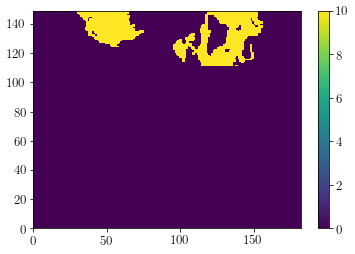

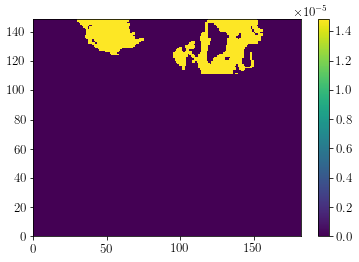

In [55]:
tgrid = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')

array = tgrid['tmask'][0,0,:,:]
hosar = np.copy(tgrid['tmask'][0,0,:,:])
hosar[111:150,79:156] = 10
hosar[124:150,20:80] = 10
hosar[np.where(array == 0)] = 0
hosar[np.where(hosar == 1)] = 0
tgrid_m2 = tgrid['tmask'][0,0,:,:] * tgrid['e1t'][0,:,:]\
* tgrid['e2t'][0,:,:]
tgrid_m2 = tgrid_m2.values
tgrid_m2[hosar < 6] = 0
plt.figure()
w = plt.pcolormesh(hosar)
plt.colorbar(w)

tot_ar = (np.sum(tgrid_m2))
hosing = 0.3 * 1e6
hosing_m = hosing/(np.sum(tot_ar))
print(hosing_m)
hosing_kg = hosing_m * 1e3
print(hosing_kg)

hosar_val = np.copy(hosar).astype(float)
hosar_val[hosar > 0] = hosing_kg
plt.figure()
w = plt.pcolormesh(hosar_val)
plt.colorbar(w)


## add hosing to 1990
hosar_val_broad = np.zeros([365,149, 182])

for i in range(0,365):
    hosar_val_broad[i,:,:] = hosar_val
    
hosar_val_broad366 = np.zeros([366,149, 182])

for i in range(0,366):
    hosar_val_broad366[i,:,:] = hosar_val



In [56]:

    
# odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
# ndir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/hosing/'
# w = xr.open_dataset(f'{odir}/era5_bulk_13_y1990.nc', decode_times=False)

# w['prra'].data = w['prra'].values + hosar_val_broad

# w.to_netcdf(f'{ndir}/era5_bulk_13_y1990.nc')
#prra:units = "kg/m^2/s" 

hos = False
if hos:
    
    odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
    ndir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/hosingArun/'
    
def hos_and_symlink(odir,ndir,yst = 1940, yen = 2025):
    
    # make destination path if doesn't exist
    os.makedirs(f'{ndir}', exist_ok=True)
    
    for yr in range(yst,yen):

        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)

        try:
            w['prra'].data = w['prra'].values + hosar_val_broad
        except:
            print(f'leap? {yr}')
            w['prra'].data = w['prra'].values + hosar_val_broad366
        w.to_netcdf(f'{ndir}/era5_bulk_13_y{yr}.nc')
        
    print('do the symlinking of non-rain things')
    for y in range(yst,yen):
        if (y%20 == 0): print(y)
        for b in range(8,16):
            if ((b != 13)):
                try:
                    src = f'{odir}/era5_bulk_{b}_y{y}.nc'
                    dst = f'{ndir}/era5_bulk_{b}_y{y}.nc'
                    os.symlink(src,dst)

                    #print(f'year {y} bulk variable {b} GO!')
                except:
                    print(f'didnt work for year {y} bulk variable {b}')
                    
        try:
            src = f'{odir}/taux_1d_y{y}.nc'
            dst = f'{ndir}/taux_1d_y{y}.nc'
            os.symlink(src,dst)

        except:
            print(f'year {y} taux is off')
        try:
            src = f'{odir}/tauy_1d_y{y}.nc'
            dst = f'{ndir}/tauy_1d_y{y}.nc'
            os.symlink(src,dst)

        except:
            print(f'year {y} tauy is off')

## make forcing that loops over one year of a base forcing

In [7]:
def create_symlinks(year_from, year_to, source_path, dest_path, yb):
    print(f"Creating symlinks from {year_from} to {year_to}, using base year {yb}")
    
    # Ensure destination path exists
    os.makedirs(dest_path, exist_ok=True)
    
    for y in range(year_from, year_to + 1):
        files = [
            (f"bulk_{yb}_11_era5_daily.nc", f"era5_bulk_11_y{y}.nc"),
            (f"bulk_{yb}_12_era5_daily.nc", f"era5_bulk_12_y{y}.nc"),
            (f"bulk_{yb}_13_era5_daily.nc", f"era5_bulk_13_y{y}.nc"),
            (f"bulk_{yb}_14_era5_daily.nc", f"era5_bulk_14_y{y}.nc"),
            (f"bulk_{yb}_15_era5_daily.nc", f"era5_bulk_15_y{y}.nc"),
            (f"bulk_{yb}_8_era5_daily.nc", f"era5_bulk_8_y{y}.nc"),
            (f"bulk_{yb}_9_era5_daily.nc", f"era5_bulk_9_y{y}.nc"),
            (f"taux_1d_{yb}_daily.nc", f"taux_1d_y{y}.nc"),
            (f"tauy_1d_{yb}_daily.nc", f"tauy_1d_y{y}.nc"),
        ]
        
        for src, dest in files:
            src_path = os.path.join(source_path, src)
            dest_path_full = os.path.join(dest_path, dest)
            
            if not os.path.exists(dest_path_full):
                os.symlink(src_path, dest_path_full)
                print(f"Created symlink: {dest_path_full} -> {src_path}")
            else:
                print(f"Symlink already exists: {dest_path_full}")
                

#### example usage

In [9]:
ex = False
if ex:
    yb = 1950
    source_path = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
    dest_path = f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/looping{yb}'#looping1990
    create_symlinks(1750, 2025, source_path, dest_path, yb)

# forcing configurations that I need to make

#### DONE 5x flux correction

    /gpfs/data/greenocean/software/products/ERA5_v202303_TJ/fc_glob5pt0

In [45]:
ex = True

odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
ndir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/fc_glob5pt0/'
scal = 5
if ex:
    make_and_symlink_flux_dirs(ndir, scal, yst = 1750, yen = 2025, \
                               odir = odir, earlyloopyr = 1990, fuldirloop = False)

#### DONE 1990 looping 

    /gpfs/data/greenocean/software/products/ERA5_v202303_TJ/looping1990

#### 1990 looping + 5x flux correction

    /gpfs/data/greenocean/software/products/ERA5_v202303_TJ/fc_glob5pt0-looping1990/

In [47]:
odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/looping1990/'
ndir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/fc_glob5pt0-looping1990/'
scal = 5.0 

ex = True

if ex:
    make_and_symlink_flux_dirs(ndir, scal, yst = 1750, yen = 2025, \
                               odir = odir, earlyloopyr = 1990, fuldirloop = True)

#### 5x flux correction + hosing

In [54]:
odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/fc_glob5pt0/'
ndir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/fc_glob5pt0-HOSE/'

ex = True

if ex:
    hos_and_symlink(odir,ndir,yst = 1940, yen = 2025)

#### no flux correction + hosing

In [98]:
odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
ndir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/HOSE/'

ex = False

if ex:
    hos_and_symlink(odir,ndir,yst = 1940, yen = 2025)

leap? 1940
leap? 1944
leap? 1948
leap? 1952
leap? 1956
leap? 1960
leap? 1964
leap? 1968
leap? 1972
leap? 1976
leap? 1980
leap? 1984
leap? 1988
leap? 1992
leap? 1996
leap? 2000
leap? 2004
leap? 2008
leap? 2012
leap? 2016
leap? 2020
leap? 2024
do the symlinking of non-rain things
1940
1960
1980
2000
2020


#### 1990 looping, no flux correction, hosing

In [99]:
odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/looping1990/'
ndir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/looping1990-HOSE/'

ex = F

if ex:
    hos_and_symlink(odir,ndir,yst = 1940, yen = 2025)

do the symlinking of non-rain things
1940
1960
1980
2000
2020


#### 1990 looping + 5x flux correction + hosing



In [58]:
odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/fc_glob5pt0-looping1990/'
ndir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/fc_glob5pt0-looping1990-HOSE/'

ex = False

if ex:
    hos_and_symlink(odir,ndir,yst = 1940, yen = 2025)

#### test that 2024 exists, and is different from 1990 base hosing, for the following



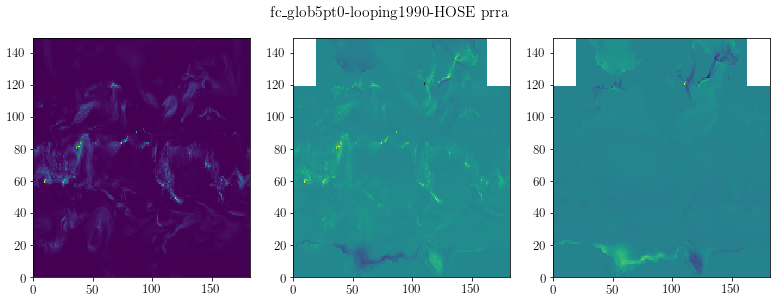

In [106]:
base = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'

option_dict = {
    "LN_HN_FN": "",
    "LN_HN_FY": "fc_glob5pt0",
    "LN_HY_FN": "HOSE",
    "LN_HY_FY": "fc_glob5pt0-HOSE",
    "LY_HN_FN": "looping1990",
    "LY_HN_FY": "fc_glob5pt0-looping1990/",
    "LY_HY_FN": "looping1990-HOSE/",
    "LY_HY_FY": "fc_glob5pt0-looping1990-HOSE/"
}

def test_diff(o1,o2,yr1,yr2,tv=30,n=13,tvar='prra'):
    
    o1dir = option_dict[o1]
    o2dir = option_dict[o2]
    w1 = xr.open_dataset(f'{base}/{o1dir}/era5_bulk_{n}_y{yr1}.nc', decode_times=False)
    w2 = xr.open_dataset(f'{base}/{o2dir}/era5_bulk_{n}_y{yr2}.nc', decode_times=False)

    fact = 1.1
    fig, axs = plt.subplots(1,3, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].pcolormesh(w1[tvar][tv,:,:])
    axs[1].pcolormesh(w2[tvar][tv,:,:])
    axs[2].pcolormesh(w1[tvar][tv,:,:]-w2[tvar][tv,:,:])
    fig.suptitle(f'{d} {tvar}')
    
o1 = 'LN_HN_FN'; yr1 = 1990
o2 = 'LN_HN_FY'; yr2 = 1990
tv = 10
test_diff(o1,o2,yr1,yr2,tv=tv,n=13,tvar='prra')

fc_glob5pt0-looping1990
fc_glob5pt0
fc_glob5pt0-HOSE
fc_glob5pt0-looping1990-HOSE


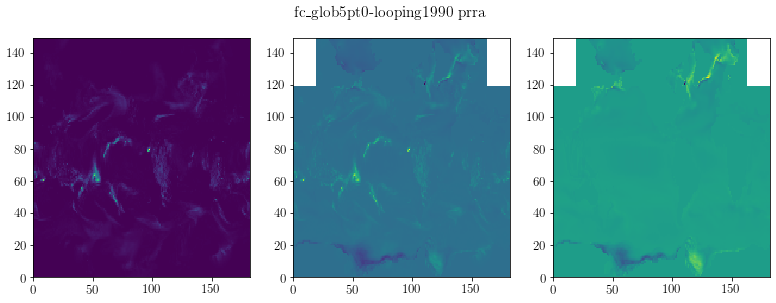

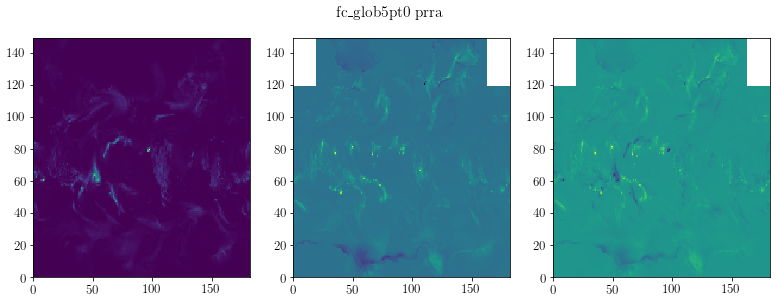

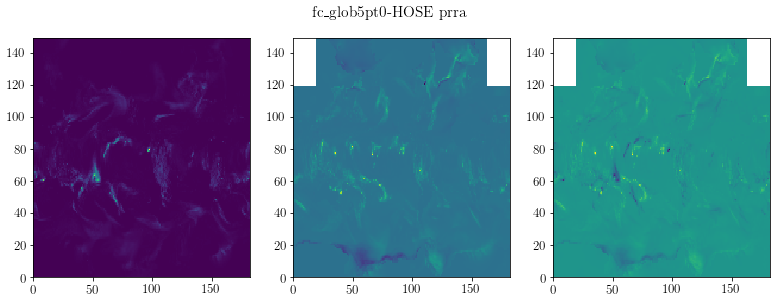

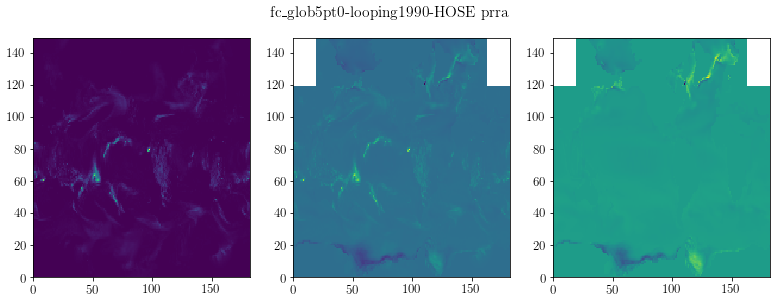

In [92]:
base = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
yrb = 1990
yr = 2024
tv = 30
dirs = ['fc_glob5pt0-looping1990', 'fc_glob5pt0', 'fc_glob5pt0-HOSE', 'fc_glob5pt0-looping1990-HOSE']

n = 13
tvar = 'prra'

for d in dirs:
    print(d)
    w2 = xr.open_dataset(f'{base}/{d}/era5_bulk_{n}_y{yr}.nc', decode_times=False)
    w = xr.open_dataset(f'{base}/era5_bulk_{n}_y{yrb}.nc', decode_times=False)

    fact = 1.1
    fig, axs = plt.subplots(1,3, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].pcolormesh(w[tvar][tv,:,:])
    axs[1].pcolormesh(w2[tvar][tv,:,:])
    axs[2].pcolormesh(w2[tvar][tv,:,:]-w[tvar][tv,:,:])
    fig.suptitle(f'{d} {tvar}')
    
# sp.tfig()

fc_glob5pt0-looping1990
fc_glob5pt0
fc_glob5pt0-HOSE
fc_glob5pt0-looping1990-HOSE


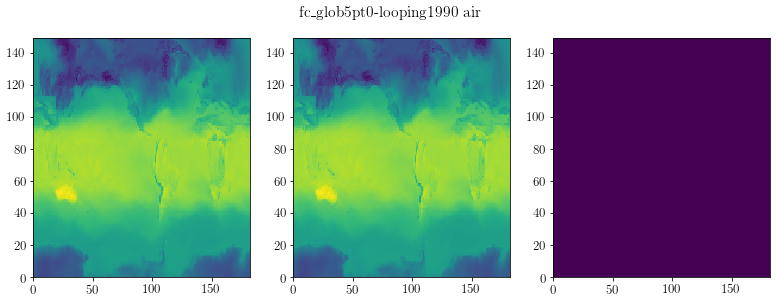

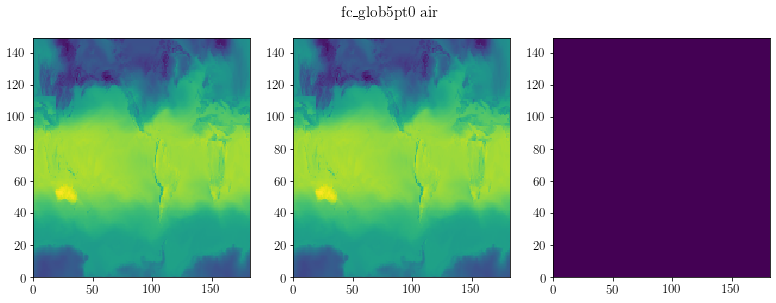

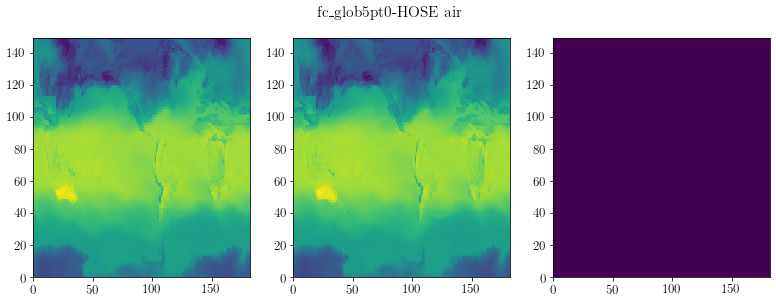

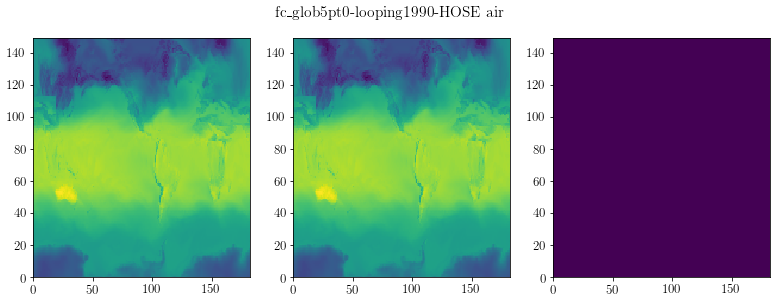

In [70]:
base = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
yrb = 1990
yr = 1990
dirs = ['fc_glob5pt0-looping1990', 'fc_glob5pt0', 'fc_glob5pt0-HOSE', 'fc_glob5pt0-looping1990-HOSE']

n = 8
tvar = 'air'

for d in dirs:
    print(d)
    w2 = xr.open_dataset(f'{base}/{d}/era5_bulk_{n}_y{yr}.nc', decode_times=False)
    w = xr.open_dataset(f'{base}/era5_bulk_{n}_y{yrb}.nc', decode_times=False)

    fact = 1.1
    fig, axs = plt.subplots(1,3, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].pcolormesh(w[tvar][tv,:,:])
    axs[1].pcolormesh(w2[tvar][tv,:,:])
    axs[2].pcolormesh(w2[tvar][tv,:,:]-w[tvar][tv,:,:])
    fig.suptitle(f'{d} {tvar}')
    
# sp.tfig()

In [68]:
w2

<xarray.Dataset>
Dimensions:       (time_counter: 365, x: 182, y: 149)
Coordinates:
  * time_counter  (time_counter) float32 9.969e+36 9.969e+36 ... 9.969e+36
Dimensions without coordinates: x, y
Data variables:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    deptht        (y, x) float32 ...
    air           (time_counter, y, x) float32 ...

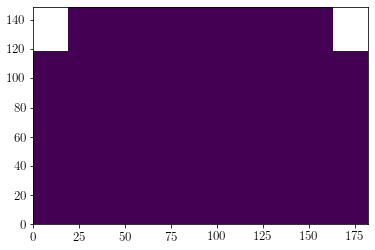

In [97]:
y = 1990
n = 13
tvar = 'prra'
tv = 30
w = xr.open_dataset\
(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/fc_glob5pt0/era5_bulk_{n}_y{y}.nc', decode_times=False)
w1 = xr.open_dataset\
(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/fc_glob5pt0-looping1990/era5_bulk_{n}_y{y}.nc', decode_times=False)

plt.pcolormesh(w1[tvar][tv,:,:] - w[tvar][tv,:,:])

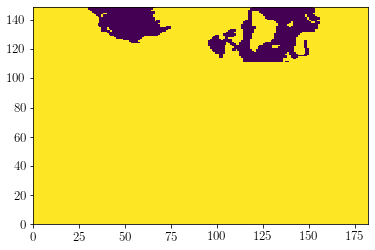

In [87]:
w1 = xr.open_dataset\
('/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/fc_glob5pt0/era5_bulk_13_y1940.nc', decode_times=False)

w2 = xr.open_dataset\
('/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/era5_bulk_13_y1940.nc', decode_times=False)

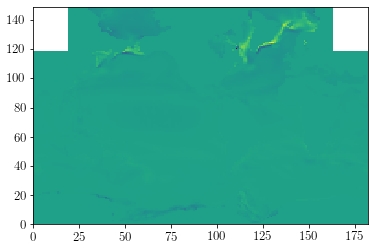

In [91]:
tv = 40
plt.pcolormesh(w1.prra[tv,:,:] - w2.prra[tv,:,:])